In [ ]:
%pip install pdfminer.six

In [1]:
import os

data_folder = "../../../Data/pdf"
file_path = os.path.join(data_folder, "S100S37P_2.pdf")
encoding = "shift-jis"

# Handle Each Page of PDF

## Retrieve texts of tables

### Step by Step confirmation

In [2]:
from pdfminer.high_level import extract_pages

pages = extract_pages(file_path)

In [3]:
# This sample has a matrinc in page 2

target_page = 9

for i, page in enumerate(pages):
    if (i+1) == target_page:
        break

The PDF <_io.BufferedReader name='../../../Data/pdf\\S100S37P_2.pdf'> contains a metadata field indicating that it should not allow text extraction. Ignoring this field and proceeding. Use the check_extractable if you want to raise an error in this case


In [4]:
# types = []
for element in page:
    print(element)
    # t = type(element)
    # if t in types:
    #     continue
    # else:
    #     types.append(t)
    #     print(t)

<LTTextBoxHorizontal(0) 52.228,792.766,178.228,803.266 '１【四半期連結財務諸表】\n'>
<LTTextBoxHorizontal(1) 61.228,778.891,196.228,787.891 '（１）【四半期連結貸借対照表】\n'>
<LTTextBoxHorizontal(2) 50.728,723.963,86.728,732.963 '資産の部\n'>
<LTTextBoxHorizontal(3) 63.728,711.509,99.728,720.509 '流動資産\n'>
<LTTextBoxHorizontal(4) 76.728,572.365,148.728,708.055 '現金及び預金\n受取手形\n電子記録債権\n売掛金\n有価証券\n商品及び製品\n仕掛品\n原材料及び貯蔵品\nその他\n貸倒引当金\n流動資産合計\n'>
<LTTextBoxHorizontal(5) 63.728,559.349,99.728,568.349 '固定資産\n'>
<LTTextBoxHorizontal(6) 76.728,546.708,130.728,555.708 '有形固定資産\n'>
<LTTextBoxHorizontal(7) 89.728,471.235,206.728,543.254 '建物及び構築物（純額）\n機械装置及び運搬具（純額）\n土地\n建設仮勘定\nその他（純額）\n有形固定資産合計\n'>
<LTTextBoxHorizontal(8) 76.728,383.013,179.728,467.219 '無形固定資産\n投資その他の資産\n投資有価証券\n繰延税金資産\nその他\n貸倒引当金\n投資その他の資産合計\n'>
<LTTextBoxHorizontal(9) 76.728,369.809,130.728,378.809 '固定資産合計\n'>
<LTTextBoxHorizontal(10) 63.728,356.605,99.728,365.605 '資産合計\n'>
<LTTextBoxHorizontal(11) 518.396,829.962,579.276,837.962 'EDINET提出書類\n'>
<LTTextBoxHorizont

#### Split line elements of a matrix

In [5]:
from pdfminer.layout import LTLine
from pdfminer.layout import LTRect

lines = []
_rects = []

for item in page:
    if isinstance(item, LTLine):
        lines.append(item)
    elif isinstance(item, LTRect):
        _rects.append(item)


class DummyLine:
    
    def __init__(self, bbox) -> None:
        self.bbox = bbox

if len(_rects) > 2:
    # splitt rects to lines
    for rect in _rects:
        x_min, y_min, x_max, y_max = rect.bbox
        left_line = DummyLine((x_min, y_min, x_min, y_max))
        right_line = DummyLine((x_max, y_min, x_max, y_max))
        top_line = DummyLine((x_min, y_max, x_max, y_max))
        bottom_line = DummyLine((x_min, y_min, x_max, y_min))
        lines.extend([left_line, right_line, top_line, right_line])
        

In [6]:
def is_near_point(p1, p2, mergin=1.0):
    if abs(p1 - p2) <= mergin:
        return True
    else:
        return False

In [7]:
def is_adj(base_node, target_node):
    x_l, y_l, x_r, y_t = base_node.bbox
    xt_l, yt_l, xt_r, yt_t = target_node.bbox
    height = abs(yt_t - yt_l)
    width = abs(xt_r - xt_l)
    # indicates (edge_type, bbox). If target_node is connected to base_node, bbox is returned.
    default_response = (-1, None)
    # edge types: 0-> left, 1-> right, 2-> top, 3-> buttom
    is_horizontal_line = abs(x_r - x_l) > 0
    is_vertical_line = abs(y_t - y_l) > 0

    if height > 0 and width > 0:
        print(f"unexpected target bbox. It is not a line: {target_node.bbox}")
        return default_response
    if is_vertical_line is True and is_horizontal_line is True:
        print(f"unexpected base bbox. It is not a line: {target_node.bbox}")
        return default_response
    if height > 0:
        # we can check eigher left or right since width is zero
        # TODO: check if boarder width is related to coordinates
        if is_horizontal_line:
            if is_near_point(y_t, yt_t):
                if is_near_point(x_l, xt_l):
                    return (0, target_node.bbox)
                elif is_near_point(x_r, xt_r):
                    return (1, target_node.bbox)
                elif (x_l < xt_l) and (x_r > xt_l):
                    return (-1, target_node.bbox)
                else:
                    # if there are multiple table or merged cell, this case happens
                    return default_response
            else:
                return default_response
        else:
            if is_near_point(x_l, xt_l):
                if is_near_point(y_t, yt_l):
                    return (2, target_node.bbox)
                elif is_near_point(y_l, yt_t):
                    return (3, target_node.bbox)
                elif (y_l < yt_l) and (y_t > yt_t):
                    return (-1, target_node.bbox)
                else:
                    return default_response
            else:
                return default_response
    elif width > 0:
        if is_vertical_line:
            if is_near_point(x_l, xt_l):
                if is_near_point(y_t, yt_t):
                    return (2, target_node.bbox)
                elif is_near_point(y_l, yt_l):
                    return (3, target_node.bbox)
                elif (y_l < yt_l) and (y_t > yt_t):
                    return (-1, target_node.bbox)
                else:
                    return default_response
            else:
                return default_response
        else:
            if is_near_point(y_t, yt_t):
                if is_near_point(x_l, xt_r):
                    return (0, target_node.bbox)
                elif is_near_point(x_r, xt_l):
                    return (1, target_node.bbox)
                elif (x_l < xt_l) and (x_r > xt_l):
                    return (-1, target_node.bbox)
                else:
                    return default_response
            else:
                return default_response
    else:
        print(f"target line seems to be a point, not a line: {target_node.bbox}")
        return default_response

In [8]:
is_adj(lines[0], lines[1])

(1, (263.22835, 735.06352, 388.22836, 735.06352))

In [9]:
target_line = lines[0]
adjs = []
others = []

for line in lines[1:]:
    edge_type, coord = is_adj(target_line, line)
    if coord is None:
        others.append(line)
    else:
        adjs.append((edge_type, line))

In [10]:
lines[0].bbox

(43.22835, 735.06352, 263.22835, 735.06352)

In [11]:
adjs

[(1, <LTLine 263.228,735.064,388.228,735.064>),
 (0, <__main__.DummyLine at 0x1faf086e5f0>),
 (1, <__main__.DummyLine at 0x1faf086c580>),
 (1, <__main__.DummyLine at 0x1faf086c580>),
 (1, <__main__.DummyLine at 0x1faf086c520>),
 (1, <__main__.DummyLine at 0x1faf086c6d0>)]

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors

[]

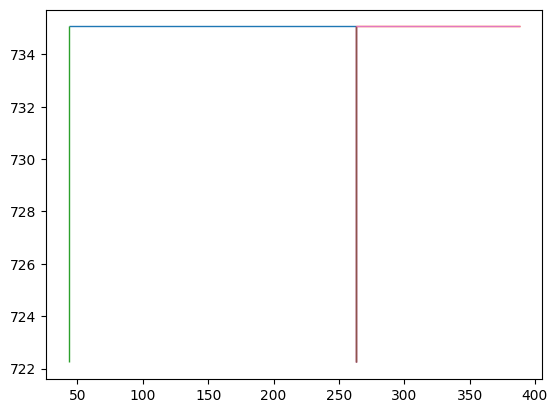

In [13]:
fig, ax = plt.subplots()
colors = list(mcolors.TABLEAU_COLORS.values())
x_min, y_min, x_max, y_max = target_line.bbox
rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor=colors[0], facecolor='none')
ax.add_patch(rectangle)

for index, line_info in enumerate(adjs):
    color_index = (index + 1) % len(colors)
    _, line = line_info
    x_min, y_min, x_max, y_max = line.bbox
    rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor=colors[color_index], facecolor='none')
    ax.add_patch(rectangle)
plt.plot()

[]

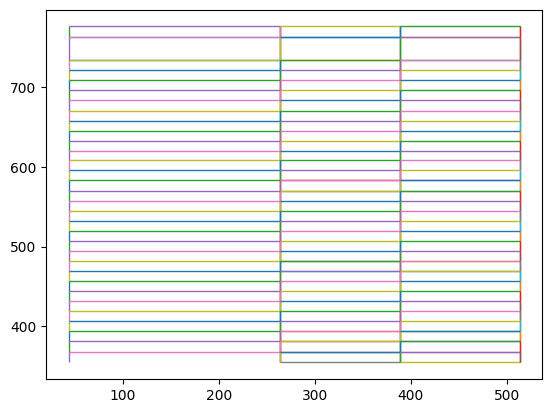

In [14]:
fig, ax = plt.subplots()
colors = list(mcolors.TABLEAU_COLORS.values())

for index, line in enumerate(lines):
    color_index = index % len(colors)
    x_min, y_min, x_max, y_max = line.bbox
    rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor=colors[color_index], facecolor='none')
    ax.add_patch(rectangle)
plt.plot()

In [15]:
def separate_adjs(target_node, remaining_nodes):
    adjs = []
    others = []
    for item in remaining_nodes:
        edge_type, coord = is_adj(target_node, item)
        if coord is None:
            others.append(item)
        else:
            adjs.append(item)
    return adjs, others

In [16]:
initial_node = lines[0]
remaining_nodes = lines[1:]
table_nodes = [initial_node]
adjs = [initial_node]

In [17]:
while len(remaining_nodes) > 0:
    pre_length = len(remaining_nodes)
    if len(adjs) > 0:
        new_adjs = []
        for adj in adjs:
            children, remaining_nodes = separate_adjs(adj, remaining_nodes)
            # print(len(children), len(remaining_nodes))
            new_adjs.extend(children)
            table_nodes.append(adj)
        adjs = new_adjs
    else:
        print("no adjs")
        break
    if pre_length == len(remaining_nodes):
        print("Stopped since remaining nodes was not changed")
        break

In [18]:
import pandas as pd

coords = []

for node in table_nodes:
    coords.append(node.bbox)

coords_df = pd.DataFrame(coords, columns=["x_min", "y_min", "x_max", "y_max"])
coords_df

,x_min,y_min,x_max,y_max
0,43.22835,735.06352,263.22835,735.06352
1,43.22835,735.06352,263.22835,735.06352
2,263.22835,735.06352,388.22836,735.06352
3,43.22835,722.23478,43.22835,735.06352
4,263.22836,722.23478,263.22836,735.06352
...,...,...,...,...
399,388.22835,354.50217,388.22835,367.70591
400,388.22835,354.50217,388.22835,367.70591
401,388.22836,354.50217,388.22836,367.70591
402,388.22836,367.70591,513.22836,367.70591


In [19]:
table_bb = (coords_df.x_min.min(), coords_df.y_min.min(), coords_df.x_max.max(), coords_df.y_max.max())
table_bb

(43.22835, 354.50217, 513.2283600000001, 776.63977)

[]

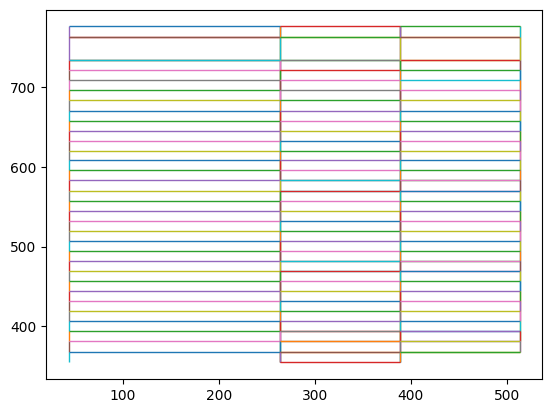

In [20]:
fig, ax = plt.subplots()

for index, node in enumerate(table_nodes):
    color_index = index % len(colors)
    x_min, y_min, x_max, y_max = node.bbox
    rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor=colors[color_index], facecolor='none')
    ax.add_patch(rectangle)
plt.plot()

#### Split txt elements of the matrix

In [21]:
from pdfminer.layout import LTTextContainer

In [22]:
txt_elements = []

for item in page:
    if isinstance(item, LTTextContainer):
        txt_elements.append(item)

In [23]:
def is_in_bb(target_out_bb, target_in_bb):
    x_min, y_min, x_max, y_max = target_out_bb
    xt_min, yt_min, xt_max, yt_max = target_in_bb

    if (x_min <= xt_min) and (y_min <= yt_min) and (x_max >= xt_max) and (y_max >= yt_max):
        return True
    else:
        return False

In [24]:
table_txt_elements = []

for item in txt_elements:
    if is_in_bb(table_bb, item.bbox):
        table_txt_elements.append(item)

In [25]:
table_txt_elements

[<LTTextBoxHorizontal(2) 50.728,723.963,86.728,732.963 '資産の部\n'>,
 <LTTextBoxHorizontal(3) 63.728,711.509,99.728,720.509 '流動資産\n'>,
 <LTTextBoxHorizontal(4) 76.728,572.365,148.728,708.055 '現金及び預金\n受取手形\n電子記録債権\n売掛金\n有価証券\n商品及び製品\n仕掛品\n原材料及び貯蔵品\nその他\n貸倒引当金\n流動資産合計\n'>,
 <LTTextBoxHorizontal(5) 63.728,559.349,99.728,568.349 '固定資産\n'>,
 <LTTextBoxHorizontal(6) 76.728,546.708,130.728,555.708 '有形固定資産\n'>,
 <LTTextBoxHorizontal(7) 89.728,471.235,206.728,543.254 '建物及び構築物（純額）\n機械装置及び運搬具（純額）\n土地\n建設仮勘定\nその他（純額）\n有形固定資産合計\n'>,
 <LTTextBoxHorizontal(8) 76.728,383.013,179.728,467.219 '無形固定資産\n投資その他の資産\n投資有価証券\n繰延税金資産\nその他\n貸倒引当金\n投資その他の資産合計\n'>,
 <LTTextBoxHorizontal(9) 76.728,369.809,130.728,378.809 '固定資産合計\n'>,
 <LTTextBoxHorizontal(10) 63.728,356.605,99.728,365.605 '資産合計\n'>,
 <LTTextBoxHorizontal(14) 289.728,739.189,361.728,758.189 '前連結会計年度\n(2023年３月31日)\n'>,
 <LTTextBoxHorizontal(15) 396.728,739.189,504.728,758.189 '当第２四半期連結会計期間\n(2023年９月30日)\n'>,
 <LTTextBoxHorizontal(16) 441.228,765.914,513

#### Specify bbox of each cell

In [26]:
# Create a table it represents cell info; cells[i, j] = bbox of i,j cell
mergin = 0.5

horizontal_lines = coords_df[coords_df.x_max - coords_df.x_min > mergin]
vertical_lines = coords_df[coords_df.y_max - coords_df.y_min > mergin]

len(horizontal_lines) + len(vertical_lines) == len(coords_df)

True

In [27]:
# coord (0, 0) is buttom left. I sort y value with descending order
left_coord = horizontal_lines[horizontal_lines.x_min == table_bb[0]]
left_coord = left_coord.sort_values(by="y_max", ascending=False)
left_coord

,x_min,y_min,x_max,y_max
60,43.22835,776.63977,263.22836,776.63977
33,43.22835,763.06103,263.22835,763.06103
35,43.22835,763.06102,263.22836,763.06102
0,43.22835,735.06352,263.22835,735.06352
1,43.22835,735.06352,263.22835,735.06352
9,43.22835,735.06352,263.22836,735.06352
16,43.22835,722.23479,263.22836,722.23479
37,43.22835,709.78105,263.22836,709.78105
62,43.22835,697.32731,263.22836,697.32731
78,43.22835,683.94523,263.22836,683.94523


In [28]:
vertical_cell_info = left_coord[["y_min", "y_max"]].reset_index(drop=True)
border_size_y = vertical_cell_info.y_max - vertical_cell_info.y_min
vertical_cell_info

,y_min,y_max
0,776.63977,776.63977
1,763.06103,763.06103
2,763.06102,763.06102
3,735.06352,735.06352
4,735.06352,735.06352
5,735.06352,735.06352
6,722.23479,722.23479
7,709.78105,709.78105
8,697.32731,697.32731
9,683.94523,683.94523


In [29]:
left_coord.y_min.iloc[:-1].values - left_coord.y_max.iloc[1:].values

array([1.35787400e+01, 9.99999997e-06, 2.79975000e+01, 0.00000000e+00,
       0.00000000e+00, 1.28287300e+01, 1.24537400e+01, 1.24537400e+01,
       1.33820800e+01, 1.33820700e+01, 1.24537300e+01, 1.24537400e+01,
       1.24537400e+01, 1.24537400e+01, 1.24537400e+01, 1.24537400e+01,
       1.23750000e+01, 1.32037400e+01, 1.28287400e+01, 1.24537300e+01,
       1.24537400e+01, 1.24537400e+01, 1.24537400e+01, 1.24537400e+01,
       1.28287400e+01, 1.32037400e+01, 1.28287400e+01, 1.24537300e+01,
       1.24537400e+01, 1.24537400e+01, 1.24537400e+01, 1.23750000e+01,
       1.32037400e+01, 1.32037400e+01])

In [30]:
# coord (0, 0) is buttom left. I sort x value with ascending order
top_coord = vertical_lines[vertical_lines.y_max == table_bb[3]]
top_coord = top_coord.sort_values(by="x_min", ascending=True)
top_coord

,x_min,y_min,x_max,y_max
34,43.22835,763.06103,43.22835,776.63977
41,263.22835,763.06103,263.22835,776.63977
39,263.22836,763.06103,263.22836,776.63977
40,263.22836,763.06103,263.22836,776.63977
52,388.22835,763.06103,388.22835,776.63977
53,388.22835,763.06103,388.22835,776.63977
54,388.22836,763.06103,388.22836,776.63977
68,513.22836,763.06103,513.22836,776.63977
69,513.22836,763.06103,513.22836,776.63977


In [31]:
horizontal_cell_info = top_coord[["x_min", "x_max"]]
horizontal_cell_info = horizontal_cell_info.reset_index(drop=True)
border_size_x = horizontal_cell_info.x_max - horizontal_cell_info.x_min
horizontal_cell_info

,x_min,x_max
0,43.22835,43.22835
1,263.22835,263.22835
2,263.22836,263.22836
3,263.22836,263.22836
4,388.22835,388.22835
5,388.22835,388.22835
6,388.22836,388.22836
7,513.22836,513.22836
8,513.22836,513.22836


In [32]:
points = []


for j, h_line in enumerate(vertical_cell_info.values):
    y = h_line[0]
    x_points = []
    for i, v_line in enumerate(horizontal_cell_info.values):
        x = v_line[0]
        x_points.append((x, y))
    points.append(x_points)

In [33]:
points_df = pd.DataFrame(points)

In [34]:
points_df

,0,1,2,3,4,5,6,7,8
0,"(43.22835, 776.63977)","(263.22835, 776.63977)","(263.22836, 776.63977)","(263.22836, 776.63977)","(388.22835, 776.63977)","(388.22835, 776.63977)","(388.22836, 776.63977)","(513.2283600000001, 776.63977)","(513.2283600000001, 776.63977)"
1,"(43.22835, 763.06103)","(263.22835, 763.06103)","(263.22836, 763.06103)","(263.22836, 763.06103)","(388.22835, 763.06103)","(388.22835, 763.06103)","(388.22836, 763.06103)","(513.2283600000001, 763.06103)","(513.2283600000001, 763.06103)"
2,"(43.22835, 763.06102)","(263.22835, 763.06102)","(263.22836, 763.06102)","(263.22836, 763.06102)","(388.22835, 763.06102)","(388.22835, 763.06102)","(388.22836, 763.06102)","(513.2283600000001, 763.06102)","(513.2283600000001, 763.06102)"
3,"(43.22835, 735.06352)","(263.22835, 735.06352)","(263.22836, 735.06352)","(263.22836, 735.06352)","(388.22835, 735.06352)","(388.22835, 735.06352)","(388.22836, 735.06352)","(513.2283600000001, 735.06352)","(513.2283600000001, 735.06352)"
4,"(43.22835, 735.06352)","(263.22835, 735.06352)","(263.22836, 735.06352)","(263.22836, 735.06352)","(388.22835, 735.06352)","(388.22835, 735.06352)","(388.22836, 735.06352)","(513.2283600000001, 735.06352)","(513.2283600000001, 735.06352)"
5,"(43.22835, 735.06352)","(263.22835, 735.06352)","(263.22836, 735.06352)","(263.22836, 735.06352)","(388.22835, 735.06352)","(388.22835, 735.06352)","(388.22836, 735.06352)","(513.2283600000001, 735.06352)","(513.2283600000001, 735.06352)"
6,"(43.22835, 722.2347900000001)","(263.22835, 722.2347900000001)","(263.22836, 722.2347900000001)","(263.22836, 722.2347900000001)","(388.22835, 722.2347900000001)","(388.22835, 722.2347900000001)","(388.22836, 722.2347900000001)","(513.2283600000001, 722.2347900000001)","(513.2283600000001, 722.2347900000001)"
7,"(43.22835, 709.78105)","(263.22835, 709.78105)","(263.22836, 709.78105)","(263.22836, 709.78105)","(388.22835, 709.78105)","(388.22835, 709.78105)","(388.22836, 709.78105)","(513.2283600000001, 709.78105)","(513.2283600000001, 709.78105)"
8,"(43.22835, 697.32731)","(263.22835, 697.32731)","(263.22836, 697.32731)","(263.22836, 697.32731)","(388.22835, 697.32731)","(388.22835, 697.32731)","(388.22836, 697.32731)","(513.2283600000001, 697.32731)","(513.2283600000001, 697.32731)"
9,"(43.22835, 683.94523)","(263.22835, 683.94523)","(263.22836, 683.94523)","(263.22836, 683.94523)","(388.22835, 683.94523)","(388.22835, 683.94523)","(388.22836, 683.94523)","(513.2283600000001, 683.94523)","(513.2283600000001, 683.94523)"


In [35]:
x = 0
y = 2

points_df.iloc[y, x]

(43.22835, 763.06102)

In [36]:
import numpy as np 

def mergin_filter(unique_array: np.ndarray, mergin):
    filtered = []
    values = unique_array.copy()
    while len(values) > 1:
        value = values[0]
        values = values[1:]
        if True in (abs(values - value) < mergin):
            continue
        filtered.append(value)
    value = values[0]
    filtered.append(value)
    return np.array(filtered)

In [37]:
import numpy as np

# method 2 to crerate point matrix
u1 = mergin_filter(vertical_lines.x_min.unique(), mergin)
u2 = mergin_filter(horizontal_lines.x_min.unique(), mergin)


additional_unique = []
for value in u2:
    if True in (abs(u1 - value) < mergin):
        continue
    additional_unique.append(value)

horizontal_points = np.array([*u1, *additional_unique])
horizontal_points.sort()
horizontal_points

array([ 43.22835, 263.22835, 388.22836, 513.22836])

In [38]:
horizontal_cell_info = top_coord[["x_min", "x_max"]]
horizontal_cell_info = horizontal_cell_info.reset_index(drop=True)
border_size_x = horizontal_cell_info.x_max - horizontal_cell_info.x_min
horizontal_cell_info

,x_min,x_max
0,43.22835,43.22835
1,263.22835,263.22835
2,263.22836,263.22836
3,263.22836,263.22836
4,388.22835,388.22835
5,388.22835,388.22835
6,388.22836,388.22836
7,513.22836,513.22836
8,513.22836,513.22836


In [39]:
import numpy as np

# method 2 to crerate point matrix
u1 = mergin_filter(vertical_lines.y_min.unique(), mergin)
u2 = mergin_filter(horizontal_lines.y_min.unique(), mergin)

additional_unique = []
for value in u2:
    if True in (abs(u1 - value) < mergin):
        continue
    additional_unique.append(value)

vertical_points = np.array([*u1, *additional_unique])
vertical_points.sort()
vertical_points

array([354.50217, 367.70591, 380.90965, 394.11339, 406.48839, 418.94213,
       431.39587, 443.8496 , 456.30334, 469.13208, 482.33582, 495.16456,
       507.6183 , 520.07204, 532.52578, 544.97951, 557.43325, 570.26199,
       583.46573, 595.84073, 608.29447, 620.74821, 633.20195, 645.65569,
       658.10942, 670.56316, 683.94524, 697.32731, 709.78105, 722.23478,
       735.06352, 763.06103, 776.63977])

In [40]:
class Point:
    
    __edges_dict = {
        8: "left", 4: "right", 2: "top", 1:"bottom",
        10: "left_top", 9: "left_bottom",
        6: "right_top", 5: "right_bottom"
    }
    
    def __init__(self, x, y) -> None:
        self.x = x
        self.y = y
        # 0:left, 1: right, 2: top, 3: bottom
        self.__lines = [None, None, None, None]
        
    @property
    def left(self):
        return self.__lines[0]
    
    @left.setter
    def left(self, value):
        self.__lines[0] = value
    
    @property
    def right(self):
        return self.__lines[1]
    
    @right.setter
    def right(self, value):
        self.__lines[1] = value
    
    @property
    def top(self):
        return self.__lines[2]
    
    @top.setter
    def top(self, value):
        self.__lines[2] = value
    
    @property
    def bottom(self):
        return self.__lines[3]
    
    @bottom.setter
    def bottom(self, value):
        self.__lines[3] = value
    
    def has_left(self):
        return self.__lines[0] is not None
    
    def has_right(self):
        return self.__lines[1] is not None
    
    def has_top(self):
        return self.__lines[2] is not None
    
    def has_bottom(self):
        return self.__lines[3] is not None
    
    def get_edge_type(self):
        b = 1 if self.__lines[0] is None else 0
        for t in self.__lines[1:]:
            b = b << 1
            if t is None:
                b += 1
        return b

    def edge_type_to_str(self, value):
        if value in self.__edges_dict:
            return self.__edges_dict[value]
        else:
            return None
    
    def __str__(self) -> str:
        return f"({self.x}, {self.y})"

In [79]:
# create point matrix

## This method is depricated since sometimes top, left cells are merged
# points = []
# for j, h_line in enumerate(vertical_cell_info.values):
#     y = h_line[0]
#     x_points = []
#     for i, v_line in enumerate(horizontal_cell_info.values):
#         x = v_line[0]
#         x_points.append(Point(x, y))
#     points.append(x_points)


In [41]:
# create point matrix

points = []
for y in reversed(vertical_points):
    x_points = []
    for x in horizontal_points:
        x_points.append(Point(x, y))
    points.append(x_points)

In [42]:
x = 1
y = 1

current_point = points[y][x]
right_point = points[y][x+1]
left_point = points[y][x-1]
top_point = points[y-1][x]
bottom_point = points[y+1][x]

In [43]:
print(current_point, right_point)

(263.22835, 763.06103) (388.22836, 763.06103)


In [44]:
for point in points[0]:
    print(point.x, point.y)

43.22835 776.63977
263.22835 776.63977
388.22836 776.63977
513.2283600000001 776.63977


In [45]:
# get_right side
def get_right_line(current_point, right_point):
    candidates = horizontal_lines[(abs(horizontal_lines.y_min - current_point.y) <= mergin)]
    _candidates = candidates[(candidates.x_min - current_point.x < mergin) & (candidates.x_max - right_point.x > -mergin)]
    if len(_candidates) > 0:
        candidates = _candidates
        candidates = candidates.sort_values(by="x_max", ascending=True)
        right_lines = candidates.iloc[0:1]
    else:
        # This case wouldn't happene with method 2
        print(f"unexpectedly found splitted lines on {current_point} for right side")
        candidates = candidates[(candidates.x_min - current_point.x > -mergin) & (candidates.x_max - right_point.x < mergin)]
        candidates = candidates.sort_values(by="x_max", ascending=True)
        right_lines = candidates
    length = len(right_lines)
    if length == 1:
        return right_lines.iloc[0]
    elif length > 1:
        print(f"found multiple lines on {current_point} for right side")
        return right_lines.iloc[0]
    else:
        return None

In [46]:
# get_left side
def get_left_line(current_point, left_point):
    candidates = horizontal_lines[(abs(horizontal_lines.y_min - current_point.y) <= mergin)]
    candidates = candidates[(candidates.x_max - current_point.x > -mergin) & (candidates.x_min - left_point.x < mergin)]
    candidates = candidates.sort_values(by="x_max", ascending=True)
    length = len(candidates)
    if length == 1:
        return candidates.iloc[0]
    elif length > 1:
        print(f"found multiple lines on {current_point} for left side")
        return candidates.iloc[0]
    else:
        return None

In [47]:
# get_bottom_side
def get_bottom_line(current_point, bottom_point):
    candidates = vertical_lines[(abs(vertical_lines.x_min - current_point.x) <= mergin)]
    candidates = candidates[(candidates.y_max - current_point.y > -mergin) & (candidates.y_min - bottom_point.y > -mergin)]
    candidates = candidates.sort_values(by="x_max", ascending=True)
    length = len(candidates)
    if length == 1:
        return candidates.iloc[0]
    elif length > 1:
        print(f"found multiple lines on {current_point} for bottom side")
        return candidates.iloc[0]
    else:
        return None

In [48]:
# get_top_side
def get_top_line(current_point, top_point):
    candidates = vertical_lines[(abs(vertical_lines.x_min - current_point.x) <= mergin)]
    candidates = candidates[(current_point.y - candidates.y_min > -mergin) & (candidates.y_max - top_point.y > -mergin)]
    candidates = candidates.sort_values(by="x_max", ascending=True)
    length = len(candidates)
    if length == 1:
        return candidates.iloc[0]
    elif length > 1:
        print(f"found multiple lines on {current_point} for right side")
        return candidates.iloc[0]
    else:
        return None

In [49]:
y_length = len(points)
for y in range(0, y_length):
    x_length = len(points[y])
    for x in range(0, x_length):
        current_point = points[y][x]
        left_point = points[y][x-1] if x > 0 else None
        right_point = points[y][x+1] if x + 1 < x_length else None
        top_point = points[y+1][x] if y + 1 < y_length else None
        bottom_point = points[y-1][x] if y > 0 else None

        if left_point is not None:
            left_line = get_left_line(current_point, left_point)
            if left_line is not None:
                current_point.left = left_line
        if right_point is not None:
            right_line = get_right_line(current_point, right_point)
            if right_line is not None:
                current_point.right = right_line
        if top_point is not None:
            top_line = get_top_line(current_point, top_point)
            if top_line is not None:
                current_point.top = top_line
        if bottom_point is not None:
            bottom_line = get_bottom_line(current_point, bottom_point)
            if bottom_line is not None:
                current_point.bottom = bottom_line

found multiple lines on (43.22835, 776.63977) for right side
found multiple lines on (263.22835, 776.63977) for right side
found multiple lines on (388.22836, 776.63977) for right side
found multiple lines on (513.2283600000001, 776.63977) for right side
found multiple lines on (43.22835, 763.06103) for right side
found multiple lines on (263.22835, 763.06103) for left side
found multiple lines on (263.22835, 763.06103) for right side
found multiple lines on (388.22836, 763.06103) for left side
found multiple lines on (388.22836, 763.06103) for right side
found multiple lines on (513.2283600000001, 763.06103) for left side
found multiple lines on (513.2283600000001, 763.06103) for right side
found multiple lines on (43.22835, 735.06352) for right side
found multiple lines on (263.22835, 735.06352) for left side
found multiple lines on (263.22835, 735.06352) for right side
found multiple lines on (263.22835, 735.06352) for bottom side
found multiple lines on (388.22836, 735.06352) for l

In [50]:
for item in points[4]:
    print(item.x, item.y)

43.22835 709.78105
263.22835 709.78105
388.22836 709.78105
513.2283600000001 709.78105


[]

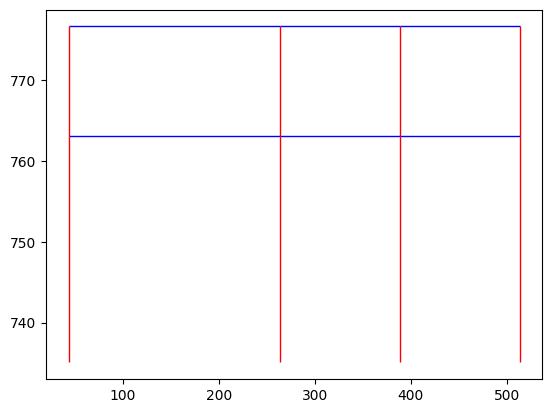

In [170]:
fig, ax = plt.subplots()

for y in range(0, 2):
    x_length = len(points[y])
    for x in range(0, x_length):
        point = points[y][x]
        if point.right is not None:
            right_line = patches.Rectangle((point.x, point.y), point.right.x_max - point.x, 0, linewidth=1, edgecolor="b", facecolor='none')
            ax.add_patch(right_line)
        if point.top is not None:
            top_line = patches.Rectangle((point.x, point.y), 0, point.top.y_max - point.y, linewidth=1, edgecolor="red", facecolor='none')
            ax.add_patch(top_line)
plt.plot()

In [65]:
cell_bbox = [[(0, 0, 0, 0) for x in range(0, len(horizontal_points) -1)] for y in range(0, len(vertical_points) -1)]

for y in range(0, y_length-1):
    for x in range(0, x_length-1):
        current_point = points[y][x]
        if cell_bbox[y][x] is None:
            continue

        next_y_point = None
        y_ = y + 1
        while next_y_point is None:
            if y_ < len(points):
                _point = points[y_][x]
                if _point.right is None:
                    if y_ < len(points)-1:
                        cell_bbox[y_][x] = None
                    else:
                        next_y_point = _point
                    y_ += 1
                else:
                    next_y_point = _point
            else:
                print(f"next y over the limit on ({x}, {y})")
                break
        
        next_x_point = None
        x_ = x + 1
        while next_x_point is None:
            if x_ < len(points[y]):
                _point = points[y][x_]
                if _point.top is None:
                    if x_ < len(points[y]) -1:
                        cell_bbox[y][x_] = None
                        x_ += 1
                    else:
                        next_x_point = _point
                else:
                    next_x_point = _point
            else:
                print(f"next x over the limit on ({x}, {y})")
                break
        
        if next_x_point is None or next_y_point is None:
            print(f"Something went worng on ({x}, {y}). {x_}: {next_x_point}, {y_}: {next_y_point}.")
            cell_bbox[y][x] = None
            continue

        # x_min, y_min, x_max, y_max. left bottom is (0, 0)
        cell_bbox[y][x] = (current_point.x, next_y_point.y, next_x_point.x, current_point.y)

In [67]:
print(cell_bbox[-2])
print(cell_bbox[-1])

[(43.22835, 367.70591, 263.22835, 380.90965), (263.22835, 367.70591, 388.22836, 380.90965), (388.22836, 367.70591, 513.2283600000001, 380.90965)]
[(43.22835, 354.50217, 263.22835, 367.70591), (263.22835, 354.50217, 388.22836, 367.70591), (388.22836, 354.50217, 513.2283600000001, 367.70591)]


In [56]:
# # fill empty cell. Sice we just check boarder of right and top side of the cell to check if it is merged or not, sometimes non-merged cell without boarder is handled as empty cell.
# for y in range(len(cell_bbox)):
#     if None in cell_bbox[y]:
#         print("None in", y, points[y])
#         new_bbox_candidate = None
#         for x in range(len(cell_bbox[y])):
#             if cell_bbox[y][x] is None:
#                 is_merge_cell = False
#                 # check horizontal cells.
#                 x_length = len(cell_bbox[y])
#                 if (x-1) < 0:
#                     # As we place merged cell to left side, this case is missed cell
#                     new_bbox_candidate = (points[y][x].x, points[y+1][x].y, points[y][x+1].x, points[y][x].y)
#                     is_merge_cell = False
#                     x_ = x
#                 else:
#                     x_ = x-1
#                     while x_ >= 0:
#                         left_cell = cell_bbox[y][x_]
#                         if left_cell is not None:
#                             _, _, x_max, _ = left_cell.bbox
#                             current_right_point_x = points[y][x+1].x
#                             if x_max >= (current_right_point_x - mergin):
#                                 new_bbox_candidate = None
#                                 is_merge_cell = True
#                             else:
#                                 new_bbox_candidate = (points[y][x].x, points[y+1][x].y, points[y][x+1].x, points[y][x].y)
#                                 is_merge_cell = False
#                             break
#                         x_ -= 1
#                     if x_ == -1:
#                         print(f"unexpected case happened on (y:{y}, x:{x})")

#                 # check vertical cells
#                 if is_merge_cell is False:
#                     if (y-1) < 0:
#                         # As we place merged cell to top side, this case is missed cell
#                         is_merge_cell = False
#                     else:
#                         y_ = y-1
#                         while y_ >= 0:
#                             # we need to consider if both x and y are merged. it is complicate
#                             top_cell = cell_bbox[y_][x_]
#                         if x_ == -1:
#                             print(f"unexpected case happened on (y:{y}, x:{x})")                    
                # else:
                #     cell_bbox[y][x] = new_bbox_candidate

None in 31 [<__main__.Point object at 0x000001FA814DC640>, <__main__.Point object at 0x000001FA814DC5E0>, <__main__.Point object at 0x000001FA814DC580>, <__main__.Point object at 0x000001FA814DC520>]


In [57]:
cell_bbox[0][0]

(43.22835, 763.06103, 263.22835, 776.63977)

In [237]:
table_txt_elements[2]

<LTTextBoxHorizontal(4) 76.728,572.365,148.728,708.055 '現金及び預金\n受取手形\n電子記録債権\n売掛金\n有価証券\n商品及び製品\n仕掛品\n原材料及び貯蔵品\nその他\n貸倒引当金\n流動資産合計\n'>

In [68]:
cell_bbox

[[(43.22835, 763.06103, 263.22835, 776.63977),
  (263.22835, 763.06103, 388.22836, 776.63977),
  (388.22836, 763.06103, 513.2283600000001, 776.63977)],
 [(43.22835, 735.06352, 263.22835, 763.06103),
  (263.22835, 735.06352, 388.22836, 763.06103),
  (388.22836, 735.06352, 513.2283600000001, 763.06103)],
 [(43.22835, 722.23478, 263.22835, 735.06352),
  (263.22835, 722.23478, 388.22836, 735.06352),
  (388.22836, 722.23478, 513.2283600000001, 735.06352)],
 [(43.22835, 709.78105, 263.22835, 722.23478),
  (263.22835, 709.78105, 388.22836, 722.23478),
  (388.22836, 709.78105, 513.2283600000001, 722.23478)],
 [(43.22835, 697.32731, 263.22835, 709.78105),
  (263.22835, 697.32731, 388.22836, 709.78105),
  (388.22836, 697.32731, 513.2283600000001, 709.78105)],
 [(43.22835, 683.94524, 263.22835, 697.32731),
  (263.22835, 683.94524, 388.22836, 697.32731),
  (388.22836, 683.94524, 513.2283600000001, 697.32731)],
 [(43.22835, 670.56316, 263.22835, 683.94524),
  (263.22835, 670.56316, 388.22836, 683.9

#### Split text by a bbox of a cell

In [69]:
table_txt_elements[2].get_text()

'現金及び預金\n受取手形\n電子記録債権\n売掛金\n有価証券\n商品及び製品\n仕掛品\n原材料及び貯蔵品\nその他\n貸倒引当金\n流動資産合計\n'

In [70]:
table_txt_elements[2].bbox

(76.72835, 572.36512, 148.72835, 708.05544)

In [71]:
cell_bbox[14]

[(43.22835, 570.26199, 263.22835, 583.46573),
 (263.22835, 570.26199, 388.22836, 583.46573),
 (388.22836, 570.26199, 513.2283600000001, 583.46573)]

In [72]:
def is_target_overwrap_to_bottom(base_bb, target_bb):
    x_min, y_min, x_max, y_max = base_bb
    xt_min, yt_min, xt_max, yt_max = target_bb

    if (x_min <= xt_min) and (x_max >= xt_max)  and (yt_max > y_min ) and (y_max - yt_max >= 0):
        return True
    else:
        return False

def is_target_overwrap_to_right(base_bb, target_bb):
    x_min, y_min, x_max, y_max = base_bb
    xt_min, yt_min, xt_max, yt_max = target_bb

    if (y_min <= yt_min) and (y_max >= yt_max)  and (x_min - xt_min >= 0) and (xt_max < xt_min):
        return True
    else:
        return False
    
def is_target_in_top(base_bb, target_bb):
    x_min, y_min, x_max, y_max = base_bb
    xt_min, yt_min, xt_max, yt_max = target_bb

    if y_min <= yt_min:
        return True
    else:
        return False

In [73]:
cell_bbox[-2]

[(43.22835, 367.70591, 263.22835, 380.90965),
 (263.22835, 367.70591, 388.22836, 380.90965),
 (388.22836, 367.70591, 513.2283600000001, 380.90965)]

In [74]:
cell_bbox[-1]

[(43.22835, 354.50217, 263.22835, 367.70591),
 (263.22835, 354.50217, 388.22836, 367.70591),
 (388.22836, 354.50217, 513.2283600000001, 367.70591)]

In [75]:
cell_texts = [["" for x in range(0, len(horizontal_points) -1)] for y in range(0, len(vertical_points) -1)]
cell_textx_postions = [[[] for x in range(0, len(horizontal_points) -1)] for y in range(0, len(vertical_points) -1)]

for y in range(len(cell_bbox)):
    for x in range(len(cell_bbox[y])):
        bbox = cell_bbox[y][x]
        if bbox is not None:
            texts = []
            positions = []
            
            for text_ele in table_txt_elements:
                if is_in_bb(bbox, text_ele.bbox) is True:
                    texts.append(text_ele.get_text())
                    positions.append((text_ele.bbox[0], text_ele.bbox[2]))
                elif is_target_overwrap_to_bottom(bbox, text_ele.bbox) is True:
                    text = text_ele.get_text()
                    
                    div_texts = text.split("\n")
                    if div_texts[-1] == "":
                        div_texts = div_texts[:-1]
                    if len(div_texts) == 1:
                        texts.append(text)
                        positions.append((text_ele.bbox[0], text_ele.bbox[2]))
                    else:
                        bottom_bb_index = None
                        for y_ in range(y+1, len(cell_bbox)):
                            next_y_bb = cell_bbox[y_][x]
                            # we should search left bb if current one is None
                            if next_y_bb is not None:
                                if is_target_in_top(next_y_bb, text_ele.bbox) is False:
                                    continue
                                else:
                                    bottom_bb_index = y_
                                    break
                        if bottom_bb_index is None:
                            texts.append(text)
                        else:
                            if len(div_texts) == (bottom_bb_index - y + 1) :
                                for index, y_ in enumerate(range(y, bottom_bb_index + 1)):
                                    cell_texts[y_][x] = div_texts[index]
                                    cell_textx_postions[y_][x].append((text_ele.bbox[0], text_ele.bbox[2]))
                            else:
                                #TODO: caliculate position of text, then add it to cell_bbox
                                #current_bbox = text_ele.bbox
                                texts.append(text)
                                positions.append((text_ele.bbox[0], text_ele.bbox[2]))
                elif is_target_overwrap_to_right(bbox, text_ele.bbox) is True:
                    texts.append(text_ele.get_text())
                    positions.append((text_ele.bbox[0], text_ele.bbox[2]))
            # it would be "" if ovwerap text is nothing
            text = cell_texts[y][x]
            new_text = "".join(texts).encode(encoding).decode(encoding).encode("utf-8").decode("utf-8")
            if text == "":
                text = new_text
            else:
                # If we need to actually support this case, it is better to handle merging them based on coords info
                text = f"{text}\n{new_text}"
            
            cell_texts[y][x] = text
            cell_textx_postions[y][x].extend(positions)

In [76]:
table = pd.DataFrame(cell_texts)
table = table.dropna(how="all")
table = table.T.dropna(how="all").T
table

,0,1,2
0,\n,\n,（単位：百万円）\n
1,\n,前連結会計年度\n(2023年３月31日)\n,当第２四半期連結会計期間\n(2023年９月30日)\n
2,資産の部\n,\n,\n
3,流動資産\n,\n,\n
4,現金及び預金\n,"21,331\n","23,041\n"
5,受取手形\n,"3,021\n","※２ 3,216\n"
6,電子記録債権\n,"4,864\n","※２ 6,317\n"
7,売掛金\n,"14,172\n","13,503\n"
8,有価証券\n,999\n,999\n
9,商品及び製品\n,"5,243\n","5,715\n"


In [301]:
table.iloc[4][0]

'現金及び預金\n受取手形\n電子記録債権\n売掛金\n有価証券\n商品及び製品\n仕掛品\n原材料及び貯蔵品\nその他\n貸倒引当金\n流動資産合計\n'

In [293]:
table.to_csv("P2-1.csv", encoding="utf-8")

### Create functions for above processes

In [18]:
# To check the logic, restart the kernel and proceed it again
from pdfminer.high_level import extract_pages

pages = extract_pages(file_path)
mergin = 0.5

In [19]:
class Point:
    
    __edges_dict = {
        8: "left", 4: "right", 2: "top", 1:"bottom",
        10: "left_top", 9: "left_bottom",
        6: "right_top", 5: "right_bottom"
    }
    
    def __init__(self, x, y) -> None:
        self.x = x
        self.y = y
        # 0:left, 1: right, 2: top, 3: bottom
        self.__lines = [None, None, None, None]
        
    @property
    def left(self):
        return self.__lines[0]
    
    @left.setter
    def left(self, value):
        self.__lines[0] = value
    
    @property
    def right(self):
        return self.__lines[1]
    
    @right.setter
    def right(self, value):
        self.__lines[1] = value
    
    @property
    def top(self):
        return self.__lines[2]
    
    @top.setter
    def top(self, value):
        self.__lines[2] = value
    
    @property
    def bottom(self):
        return self.__lines[3]
    
    @bottom.setter
    def bottom(self, value):
        self.__lines[3] = value
    
    def has_left(self):
        return self.__lines[0] is not None
    
    def has_right(self):
        return self.__lines[1] is not None
    
    def has_top(self):
        return self.__lines[2] is not None
    
    def has_bottom(self):
        return self.__lines[3] is not None
    
    def get_edge_type(self):
        b = 1 if self.__lines[0] is None else 0
        for t in self.__lines[1:]:
            b = b << 1
            if t is None:
                b += 1
        return b

    def edge_type_to_str(self, value):
        if value in self.__edges_dict:
            return self.__edges_dict[value]
        else:
            return None
    
    def __str__(self) -> str:
        return f"({self.x}, {self.y})"

In [20]:
import numpy as np
import pandas as pd
from pdfminer.layout import LTLine
from pdfminer.layout import LTPage
from pdfminer.layout import LTTextContainer


def is_near_point(p1, p2, mergin=1.0):
    if abs(p1 - p2) <= mergin:
        return True
    else:
        return False
    
def retrieve_lines(page):
    lines = []
    for item in page:
        if isinstance(item, LTLine):
            lines.append(item)
    return lines

def is_adj(base_node, target_node):
    x_l, y_l, x_r, y_t = base_node.bbox
    xt_l, yt_l, xt_r, yt_t = target_node.bbox
    height = abs(yt_t - yt_l)
    width = abs(xt_r - xt_l)
    # indicates (edge_type, bbox). If target_node is connected to base_node, bbox is returned.
    default_response = (-1, None)
    # edge types: 0-> left, 1-> right, 2-> top, 3-> buttom
    is_horizontal_line = abs(x_r - x_l) > 0
    is_vertical_line = abs(y_t - y_l) > 0

    if height > 0 and width > 0:
        print(f"unexpected target bbox. It is not a line: {target_node.bbox}")
        return default_response
    if is_vertical_line is True and is_horizontal_line is True:
        print(f"unexpected base bbox. It is not a line: {target_node.bbox}")
        return default_response
    if height > 0:
        # we can check eigher left or right since width is zero
        # TODO: check if boarder width is related to coordinates
        if is_horizontal_line:
            if is_near_point(y_t, yt_t):
                if is_near_point(x_l, xt_l):
                    return (0, target_node.bbox)
                elif is_near_point(x_r, xt_r):
                    return (1, target_node.bbox)
                elif (x_l < xt_l) and (x_r > xt_l):
                    return (-1, target_node.bbox)
                else:
                    # if there are multiple table or merged cell, this case happens
                    return default_response
            else:
                return default_response
        else:
            if is_near_point(x_l, xt_l):
                if is_near_point(y_t, yt_l):
                    return (2, target_node.bbox)
                elif is_near_point(y_l, yt_t):
                    return (3, target_node.bbox)
                elif (y_l < yt_l) and (y_t > yt_t):
                    return (-1, target_node.bbox)
                else:
                    return default_response
            else:
                return default_response
    elif width > 0:
        if is_vertical_line:
            if is_near_point(x_l, xt_l):
                if is_near_point(y_t, yt_t):
                    return (2, target_node.bbox)
                elif is_near_point(y_l, yt_l):
                    return (3, target_node.bbox)
                elif (y_l < yt_l) and (y_t > yt_t):
                    return (-1, target_node.bbox)
                else:
                    return default_response
            else:
                return default_response
        else:
            if is_near_point(y_t, yt_t):
                if is_near_point(x_l, xt_r):
                    return (0, target_node.bbox)
                elif is_near_point(x_r, xt_l):
                    return (1, target_node.bbox)
                elif (x_l < xt_l) and (x_r > xt_l):
                    return (-1, target_node.bbox)
                else:
                    return default_response
            else:
                return default_response
    else:
        print(f"target line seems to be a point, not a line: {target_node.bbox}")
        return default_response

def separate_adjs(target_node, remaining_nodes):
    adjs = []
    others = []
    for item in remaining_nodes:
        edge_type, coord = is_adj(target_node, item)
        if coord is None:
            others.append(item)
        else:
            adjs.append(item)
    return adjs, others

def retrieve_a_table_lines(target_lines: list):
    initial_node = target_lines[0]
    table_nodes = [initial_node]
    adjs = [initial_node]
    remaining_nodes = target_lines[1:].copy()
    while len(remaining_nodes) > 0:
        pre_length = len(remaining_nodes)
        if len(adjs) > 0:
            new_adjs = []
            for adj in adjs:
                children, remaining_nodes = separate_adjs(adj, remaining_nodes)
                # print(len(children), len(remaining_nodes))
                # adj.merge_child(children)
                new_adjs.extend(children)
                table_nodes.append(adj)
            adjs = new_adjs
        else:
            # print("no adjs")
            break
        if pre_length == len(remaining_nodes):
            # print("Stopped since remaining nodes was not changed")
            break
    return table_nodes, remaining_nodes

def to_bbox_df(table_lines):
    coords = []
    for node in table_lines:
        coords.append(node.bbox)

    coords_df = pd.DataFrame(coords, columns=["x_min", "y_min", "x_max", "y_max"])
    table_bb = (coords_df.x_min.min(), coords_df.y_min.min(), coords_df.x_max.max(), coords_df.y_max.max())
    return coords_df, table_bb

def retrieve_text_elements(page):
    txt_elements = []

    for item in page:
        if isinstance(item, LTTextContainer):
            txt_elements.append(item)
    return txt_elements

def is_in_bb(target_out_bb, target_in_bb):
    x_min, y_min, x_max, y_max = target_out_bb
    xt_min, yt_min, xt_max, yt_max = target_in_bb

    if (x_min <= xt_min) and (y_min <= yt_min) and (x_max >= xt_max) and (y_max >= yt_max):
        return True
    else:
        return False
    
def get_txt_for_table(table_bb, txt_elements=None, page=None):
    if txt_elements is None and page is None:
        raise ValueError("either txt_elements or page is required.")
    table_txt_elements = []
    if txt_elements is not None:
        for item in txt_elements:
            if is_in_bb(table_bb, item.bbox):
                table_txt_elements.append(item)
    elif page is not None:
        for item in page:
            if isinstance(item, LTTextContainer):
                if is_in_bb(table_bb, item.bbox):
                    table_txt_elements.append(item)
    return table_txt_elements

def split_hv_lines(data):
    if isinstance(data, list):
        coord_df, _ = to_bbox_df(data)
    elif isinstance(data, pd.DataFrame):
        coord_df = data
    horizontal_lines = data[data.x_max - data.x_min > mergin]
    vertical_lines = data[data.y_max - data.y_min > mergin]
    return horizontal_lines, vertical_lines

def create_unique_points(horizontal_lines, vertical_lines):
    u1 = vertical_lines.x_min.unique()
    u2 = horizontal_lines.x_min.unique()

    additional_unique = []
    for value in u2:
        if True in (abs(u1 - value) < mergin):
            continue
        additional_unique.append(value)

    horizontal_points = np.array([*u1, *additional_unique])
    horizontal_points.sort()

    u1 = vertical_lines.y_min.unique()
    u2 = horizontal_lines.y_min.unique()

    additional_unique = []
    for value in u2:
        if True in (abs(u1 - value) < mergin):
            continue
        additional_unique.append(value)

    vertical_points = np.array([*u1, *additional_unique])
    vertical_points.sort()

    return horizontal_points, vertical_points

def create_matrix(horizontal_points, vertical_points):
    points = []
    for y in vertical_points:
        x_points = []
        for x in horizontal_points:
            x_points.append(Point(x, y))
        points.append(x_points)
    return points


# get_right side
def get_right_line(current_point, right_point, horizontal_lines):
    candidates = horizontal_lines[(abs(horizontal_lines.y_min - current_point.y) <= mergin)]
    candidates = candidates[(candidates.x_min - current_point.x < mergin) & (candidates.x_max - right_point.x > -mergin)]
    candidates = candidates.sort_values(by="x_max", ascending=True)
    right_lines = candidates.iloc[0:1]
    length = len(right_lines)
    if length == 1:
        return right_lines.iloc[0]
    elif length > 1:
        # print(f"found multiple lines on {current_point} for right side")
        return right_lines.iloc[0]
    else:
        return None
    
# get_left side
def get_left_line(current_point, left_point, horizontal_lines):
    candidates = horizontal_lines[(abs(horizontal_lines.y_min - current_point.y) <= mergin)]
    candidates = candidates[(candidates.x_max - current_point.x > -mergin) & (candidates.x_min - left_point.x < mergin)]
    candidates = candidates.sort_values(by="x_max", ascending=True)
    length = len(candidates)
    if length == 1:
        return candidates.iloc[0]
    elif length > 1:
        # print(f"found multiple lines on {current_point} for left side")
        return candidates.iloc[0]
    else:
        return None
    
# get_bottom_side
def get_bottom_line(current_point, bottom_point, vertical_lines):
    candidates = vertical_lines[(abs(vertical_lines.x_min - current_point.x) <= mergin)]
    candidates = candidates[(candidates.y_max - current_point.y > -mergin) & (candidates.y_min - bottom_point.y > -mergin)]
    candidates = candidates.sort_values(by="x_max", ascending=True)
    length = len(candidates)
    if length == 1:
        return candidates.iloc[0]
    elif length > 1:
        # print(f"found multiple lines on {current_point} for bottom side")
        return candidates.iloc[0]
    else:
        return None
    
# get_top_side
def get_top_line(current_point, top_point, vertical_lines):
    candidates = vertical_lines[(abs(vertical_lines.x_min - current_point.x) <= mergin)]
    candidates = candidates[(current_point.y - candidates.y_min > -mergin) & (candidates.y_max - top_point.y > -mergin)]
    candidates = candidates.sort_values(by="x_max", ascending=True)
    length = len(candidates)
    if length == 1:
        return candidates.iloc[0]
    elif length > 1:
        # print(f"found multiple lines on {current_point} for right side")
        return candidates.iloc[0]
    else:
        return None
    
def create_unique_points_matrix(horizontal_lines, vertical_lines):
    h_points, v_points = create_unique_points(horizontal_lines, vertical_lines)
    points = create_matrix(h_points, v_points)
    y_length = len(points)
    for y in range(0, y_length):
        x_length = len(points[y])
        for x in range(0, x_length):
            current_point = points[y][x]
            left_point = points[y][x-1] if x > 0 else None
            right_point = points[y][x+1] if x + 1 < x_length else None
            top_point = points[y+1][x] if y + 1 < y_length else None
            bottom_point = points[y-1][x] if y > 0 else None

            if left_point is not None:
                left_line = get_left_line(current_point, left_point, horizontal_lines)
                if left_line is not None:
                    current_point.left = left_line
            if right_point is not None:
                right_line = get_right_line(current_point, right_point, horizontal_lines)
                if right_line is not None:
                    current_point.right = right_line
            if top_point is not None:
                top_line = get_top_line(current_point, top_point, vertical_lines)
                if top_line is not None:
                    current_point.top = top_line
            if bottom_point is not None:
                bottom_line = get_bottom_line(current_point, bottom_point, vertical_lines)
                if bottom_line is not None:
                    current_point.bottom = bottom_line
    return points

def create_cellar_matrix(points):
    y_length = len(points)
    x_length = len(points[0])
    # length - 1 as cell is less than intersection points
    cell_bbox = [[(0, 0, 0, 0) for x in range(0, x_length -1)] for y in range(0, y_length -1)]
    for y in range(0, y_length-1):
        for x in range(0, x_length-1):
            current_point = points[y][x]
            if cell_bbox[y][x] is None:
                continue

            next_y_point = None
            y_ = y + 1
            while next_y_point is None:
                if y_ < len(points):
                    _point = points[y_][x]
                    if _point.right is None:
                        cell_bbox[y_][x] = None
                        y_ += 1
                    else:
                        next_y_point = _point
                else:
                    print(f"next y over the limit on ({x}, {y})")
                    break
            
            next_x_point = None
            x_ = x + 1
            while next_x_point is None:
                if x_ < len(points[y]):
                    _point = points[y][x_]
                    if _point.bottom is None:
                        if x_ < len(points[y]) -1:
                            y_limit = y_ if y_ < len(cell_bbox) else len(cell_bbox)
                            for temp_y in range(y, y_limit):
                                cell_bbox[temp_y][x_] = None
                        x_ += 1
                    else:
                        next_x_point = _point
                else:
                    # print(f"next x over the limit on ({x}, {y})")
                    break
            
            if next_x_point is None or next_y_point is None:
                # print(f"Something went worng on ({x}, {y}). {x_}: {next_x_point}, {y_}: {next_y_point}.")
                cell_bbox[y][x] = None
                continue

            # x_min, y_min, x_max, y_max. left bottom is (0, 0)
            cell_bbox[y][x] = (current_point.x, current_point.y, next_x_point.x, next_y_point.y)
    return cell_bbox

def retrieve_texts_of_cell(cellar_matrix, table_elements, source_encoding="utf-8", to_encoding="utf-8"):
    cell_texts = [[None for x in range(0, len(cellar_matrix[0]))] for y in range(0, len(cellar_matrix))]

    for y in range(len(cellar_matrix)):
        for x in range(len(cellar_matrix[y])):
            bbox = cellar_matrix[y][x]
            if bbox is not None:
                texts = []
                
                for text_ele in table_elements:
                    if is_in_bb(bbox, text_ele.bbox) is True:
                        texts.append(text_ele.get_text())
                cell_texts[y][x] = "".join(texts).encode(source_encoding).decode(source_encoding).encode(to_encoding).decode(to_encoding)
    return cell_texts

def save_to_csv(cell_texts, path, encoding="utf-8"):
    table = pd.DataFrame(reversed(cell_texts))
    table[table == ""] = np.NaN
    table[table == "\n"] = np.NaN
    table = table.dropna(how="all")
    table = table.T.dropna(how="all").T
    if len(table) > 0:
        table.fillna("", inplace=True)
        table.to_csv(path, encoding=encoding)

In [21]:
for page_num, page in enumerate(pages):
    texts = retrieve_text_elements(page)
    lines = retrieve_lines(page)
    
    if lines is not None and len(lines) > 3:
        table_lines, remaining = retrieve_a_table_lines(lines)
        pre_length = -1
        if table_lines is not None:
            table_lines_array = [table_lines]
        else:
            table_lines_array = []

        while len(remaining) > 0 and pre_length != len(remaining):
            pre_length = len(remaining)
            table_lines, remaining = retrieve_a_table_lines(remaining)
            if len(table_lines) > 3:
                table_lines_array.append(table_lines)
            elif len(table_lines) == 0:
                remaining = remaining[1:]

        print(f"found {len(table_lines_array)} table(s) on {page_num}.")

        for index, table_lines in enumerate(table_lines_array):
            coord_df, table_bbox = to_bbox_df(table_lines)
            table_text_elements = get_txt_for_table(table_bbox, texts)
            h_lines, v_lines = split_hv_lines(coord_df)
            points = create_unique_points_matrix(h_lines, v_lines)
            celler_matrix = create_cellar_matrix(points)
            cell_texts = retrieve_texts_of_cell(celler_matrix, table_text_elements, source_encoding="utf-8")
            save_to_csv(cell_texts, f"./test_table_texts_{page_num}_t-{index}.csv")
    else:
        print(f"no table found on {page_num}")

The PDF <_io.BufferedReader name='../../../Data/pdf\\S100S37P_2.pdf'> contains a metadata field indicating that it should not allow text extraction. Ignoring this field and proceeding. Use the check_extractable if you want to raise an error in this case


no table found on 0
found 2 table(s) on 1.
no table found on 2
no table found on 3
found 3 table(s) on 4.
found 2 table(s) on 5.
found 2 table(s) on 6.
no table found on 7
found 1 table(s) on 8.
found 1 table(s) on 9.
found 1 table(s) on 10.
found 1 table(s) on 11.
found 5 table(s) on 12.
found 8 table(s) on 13.
found 2 table(s) on 14.
found 2 table(s) on 15.
found 1 table(s) on 16.
no table found on 17
found 1 table(s) on 18.
no table found on 19
